## Нелинейная аппроксимация

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

#### Генерация набора данных

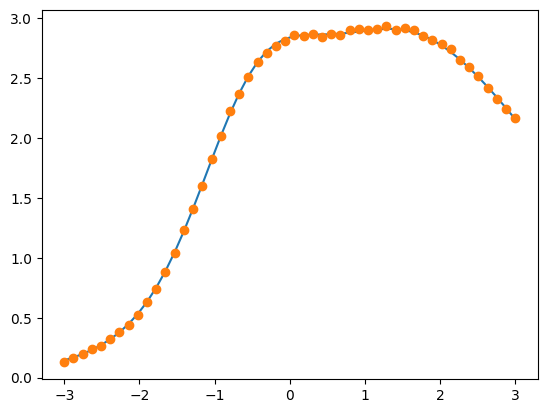

In [2]:
n = 50
x = np.linspace(-3, 3, n)

# Combination of three Gauss functions
y = 1.*np.exp(-((x + 0.5) / 1)**2) +  1.*np.exp(-((x - 1.0) / 2)**2) + 1.0*2.*np.exp(-((x - 2.0) / 3)**2)
y_true = y + 0.01*np.random.normal(0, 1, n)

plt.plot(x, y, '-');
plt.plot(x, y_true, 'o');

#### Разложение аппроксимирующей функции по радиальным базисным функциям

$y=\sum\limits_{i=1}^m{a_i\varphi_i(x)}\hspace{10mm}\varphi_i=\mathrm{e}^{-\left(\dfrac{x-b_i}{d_i}\right)^2}$
  
Представим параметры $a, b, d$ в виде одного вектора $w$ как их последовательную конкатенацию
  
$y=\sum\limits_{i=1}^m{w_i\varphi_i(x)}\hspace{10mm}\varphi_i=\mathrm{e}^{-\left(\dfrac{x-w_{i+m}}{w_{i+2m}}\right)^2}$

In [3]:
def basis_functions(w, x):
    basis = np.ndarray((len(x), m))
    for i in range(len(x)):
        basis[i] = np.exp(-((x[i] - w[m:m*2]) / w[m*2:m*3])**2)
    return np.sum(basis*w[:m], axis=1)

#### Производные аппроксимирующей функции по параметрам

$\dfrac{\partial y}{\partial a_i}=\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}$
  
$\dfrac{\partial y}{\partial b_i}=\dfrac{2a_i\left(x-b_i\right)\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^2}$
  
$\dfrac{\partial y}{\partial d_i}=\dfrac{2a_i\left(x-b_i\right)^2\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^3}$

In [4]:
def basis_functions_deriv(w, x):
    deriv = np.zeros((3*m, len(x)))
    for i in range(3*m):
        if i < m: # a
            deriv[i] = np.exp(-((x - w[m+i]) / w[m*2+i])**2)
        elif i < 2*m: # b
            expon = np.exp(-((x - w[i]) / w[m+i])**2)
            deriv[i] = (2*w[i-m]*(x-w[i])*expon)/(w[i+m]**2)
        elif i < 3*m: # d
            expon = np.exp(-((x - w[i-m]) / w[i])**2)
            deriv[i] =(2*w[i-2*m]*((x-w[i-m])**2)*expon)/(w[i]**3)
    
    return deriv

#### Вторые производные аппроксимирующей функции по параметрам

$\dfrac{\partial^2 y}{\partial a_i \partial a_j}=0\hspace{10mm}\forall{i,j}$
  
$\dfrac{\partial^2 y}{\partial a_i \partial b_j}=\dfrac{2\left(x-b_i\right)\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^2}\hspace{10mm}i=j$
  
$\dfrac{\partial^2 y}{\partial a_i \partial d_j}=\dfrac{2\left(x-b_i\right)^2\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^3}\hspace{10mm}i=j$
  
---------
$\dfrac{\partial^2 y}{\partial b_i \partial a_j}=\dfrac{2\left(x-b_i\right)\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^2}\hspace{10mm}i=j$
  
$\dfrac{\partial^2 y}{\partial b_i \partial b_j}=\dfrac{2a_i\left(2x^2-4xb_i+2x^2-d_i^2\right)\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^4}\hspace{10mm}i=j$
  
$\dfrac{\partial^2 y}{\partial b_i \partial d_j}=\dfrac{4a_i\left(b_i-x\right)\left(d_i^2-b_i^2+2xb_i-x^2\right)\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^5}\hspace{10mm}i=j$
  
---------
$\dfrac{\partial^2 y}{\partial d_i \partial a_j}=\dfrac{2\left(x-b_i\right)^2\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^3}\hspace{10mm}i=j$
  
$\dfrac{\partial^2 y}{\partial d_i \partial b_j}=\dfrac{4a_i\left(b_i-x\right)\left(d_i^2-b_i^2+2xb_i-x^2\right)\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^5}\hspace{10mm}i=j$
  
$\dfrac{\partial^2 y}{\partial d_i \partial d_j}=-\dfrac{2a_i\left(x-b_i\right)^2\left(3d_i^2-2b_i^2+4xb_i-2x^2\right)\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^6}\hspace{10mm}i=j$

In [5]:
def basis_functions_hess(w, x):
    hess = np.zeros((3*m, 3*m, len(x)))
    for i in range(3*m):
        if i < m: # a
            a = w[i]
            b = w[i+m]
            d = w[i+2*m]
            expon = np.exp(-((x - b) / d)**2)
            hess[i, i+m] = (2*(x-b)*expon)/(d**2)
            hess[i, i+2*m] = (2*((x-b)**2)*expon)/(d**3)
            
        elif i < 2*m: # b
            a = w[i-m]
            b = w[i]
            d = w[i+m]
            expon = np.exp(-((x - b) / d)**2)
            hess[i, i-m] = (2*(x-b)*expon)/(d**2)
            hess[i, i] = 2*a*(2*(b**2) - 4*x*b + 2*(x**2) - d**2)*expon/(d**4)
            hess[i, i+m] = -4*a*(b-x)*(b**2 - 2*x*b + x**2 - d**2)*expon/(d**5)
            
        elif i < 3*m: # d
            a = w[i-2*m]
            b = w[i-m]
            d = w[i]
            expon = np.exp(-((x - b) / d)**2)
            hess[i, i-2*m] = (2*((x-b)**2)*expon)/(d**3)
            hess[i, i-m] = -4*a*(x-b)*(d**2 - x**2 + 2*x*b - b**2)*expon/(d**5)
            hess[i, i] = -2*a*((x-b)**2)*(3*(d**2) - 2*(x**2) + 4*b*x - 2*(b**2))*expon/(d**6)
    
    return hess

#### Функция ошибки аппроксимации

$error = \sum\limits_{i=1}^n{\left(y_i-y_{true_i}\right)^2}$

In [6]:
def error_func(w):
    basis = basis_functions(w, x)
    error = 0
    for i in range(len(y_true)):
        error += (basis[i] - y_true[i])**2
    return error

#### Градиент целевой функции 

$\dfrac{\partial error}{\partial w_j} = 2\sum\limits_{i=1}^n{\dfrac{\partial y_i}{\partial w_j}\left(y_i-y_{true_i}\right)}$

In [7]:
def error_func_deriv(w):
    basis = basis_functions(w, x)
    basis_deriv = basis_functions_deriv(w, x)
    error_deriv = np.zeros(3*m)
    for i in range(3*m):
        error_deriv[i] = 2*np.sum((basis - y_true)*basis_deriv[i], axis=0)
    return error_deriv

#### Матрица Гессе целевой функции 

$\dfrac{\partial error}{\partial w_j \partial w_k} = 2\sum\limits_{i=1}^n{\left(\dfrac{\partial y_i}{\partial w_j}\dfrac{\partial y_i}{\partial w_k} + \dfrac{\partial^2 y_i}{\partial w_j \partial w_k}\left(y_i-y_{true_i}\right)\right)}$

In [8]:
def error_func_hess(w):
    basis = basis_functions(w, x)
    basis_deriv = basis_functions_deriv(w, x)
    basis_hess = basis_functions_hess(w, x)
    error_hess = np.zeros((3*m, 3*m))
    for i in range(3*m):
        for j in range(3*m):
            error_hess[i,j] = 2*np.sum((basis_deriv[i]*basis_deriv[j] + basis_hess[i,j]*(basis - y_true)), axis=0)
    return error_hess

#### Задание начального приближения

In [9]:
m = 3 # number of basis functions
a = np.random.normal(loc=0,scale=3,size=m)
a = [1.0, 1.0, 1.0]
b = np.random.normal(loc=0,scale=1,size=m)
b = [0., 1., 1.5]
d = np.random.normal(loc=0,scale=1,size=m)
d = [2, 2, 2]
w = np.concatenate((a,b,d))
np.set_printoptions(precision=3, suppress=True)
print('Начальные параметры')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(w[i], w[i+m], w[i+2*m]))

Начальные параметры
a:   1.000   b:   0.000   d:   2.000
a:   1.000   b:   1.000   d:   2.000
a:   1.000   b:   1.500   d:   2.000


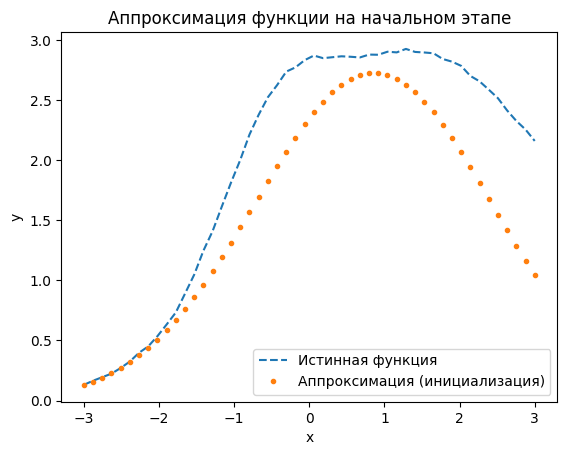

Начальная ошибка: 13.988557945849182


In [26]:
plt.plot(x, y_true, '--')
plt.plot(x, basis_functions(w, x), '.');
print('Начальная ошибка:', error_func(w))

#### Минимизация методом 0-го порядка

Optimization terminated successfully.
         Current function value: 0.047918
         Iterations: 1475
         Function evaluations: 2103

Параметры аппроксимирующей функции после оптимизации
a:   2.781   b:  -0.005   d:   1.575
a:   2.151   b:   2.674   d:   1.331
a:   0.823   b:   1.480   d:   0.840
Ошибка после минимизации: 0.047917524311687644
CPU times: user 615 ms, sys: 1.17 ms, total: 616 ms
Wall time: 627 ms


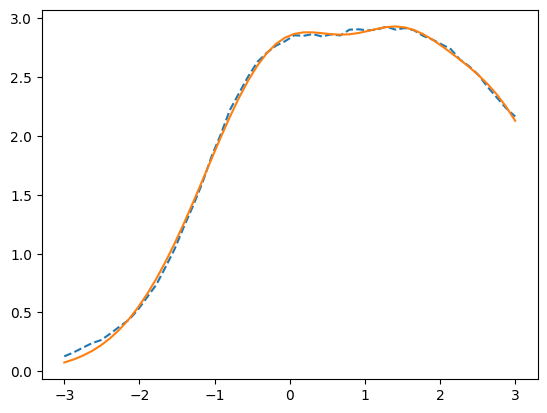

In [11]:
%%time
res = minimize(error_func, w, method='Nelder-Mead',options={'maxiter':10000,'disp': True})
print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
print('Ошибка после минимизации:', res.fun)
plt.plot(x, y_true, '--')
#plt.plot(x, basis_functions(w, x), '.')
plt.plot(x, basis_functions(res.x, x));

#### Минимизация методом 1-го порядка

Optimization terminated successfully.
         Current function value: 0.004964
         Iterations: 168
         Function evaluations: 196
         Gradient evaluations: 196

Параметры аппроксимирующей функции после оптимизации
a:   0.992   b:  -0.520   d:   0.988
a:   0.557   b:   0.811   d:   1.739
a:   2.449   b:   1.795   d:   2.812
Ошибка после минимизации: 0.00496410214907709
CPU times: user 188 ms, sys: 89 μs, total: 188 ms
Wall time: 187 ms


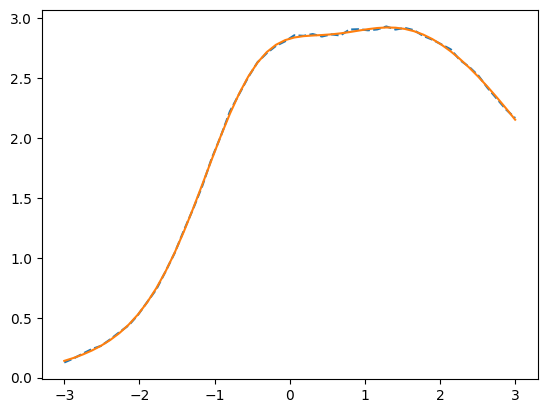

In [12]:
%%time
res = minimize(error_func, w, method='BFGS', jac=error_func_deriv, options={'maxiter':10000, 'disp': True})
#res = minimize(error_func, w, method='BFGS', options={'maxiter':10000, 'disp': True})
print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
print('Ошибка после минимизации:', res.fun)
plt.plot(x, y_true, '--')
#plt.plot(x, basis_functions(w, x), '.')
plt.plot(x, basis_functions(res.x, x));

#### Минимизация методом 2-го порядка

Optimization terminated successfully.
         Current function value: 0.004965
         Iterations: 95
         Function evaluations: 140
         Gradient evaluations: 140
         Hessian evaluations: 95

Параметры аппроксимирующей функции после оптимизации
a:   0.988   b:  -0.519   d:   0.988
a:   0.643   b:   0.842   d:   1.804
a:   2.368   b:   1.832   d:   2.842
Ошибка после минимизации: 0.004965129921513412
CPU times: user 219 ms, sys: 150 μs, total: 219 ms
Wall time: 217 ms


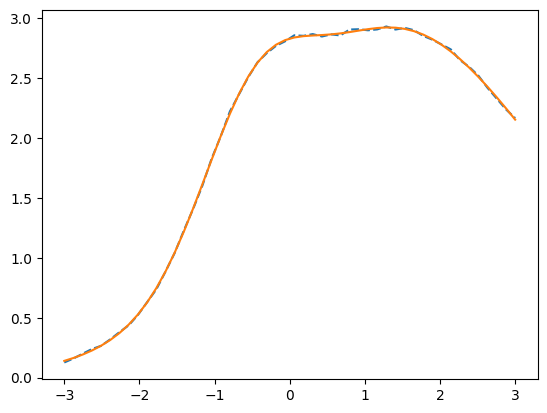

In [13]:
%%time
res = minimize(error_func, w, method='Newton-CG', jac=error_func_deriv, hess=error_func_hess, options={'maxiter':10000, 'disp': True})
print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
print('Ошибка после минимизации:', res.fun)
plt.plot(x, y_true, '--')
#plt.plot(x, basis_functions(w, x), '.')
plt.plot(x, basis_functions(res.x, x));

#### Минимизация с ограничениями

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.005196182782910667
            Iterations: 35
            Function evaluations: 362
            Gradient evaluations: 35

Параметры аппроксимирующей функции после оптимизации
a:   0.918   b:  -0.511   d:   0.965
a:   1.666   b:   0.986   d:   2.270
a:   1.449   b:   2.417   d:   3.000
CPU times: user 121 ms, sys: 1.02 ms, total: 122 ms
Wall time: 121 ms


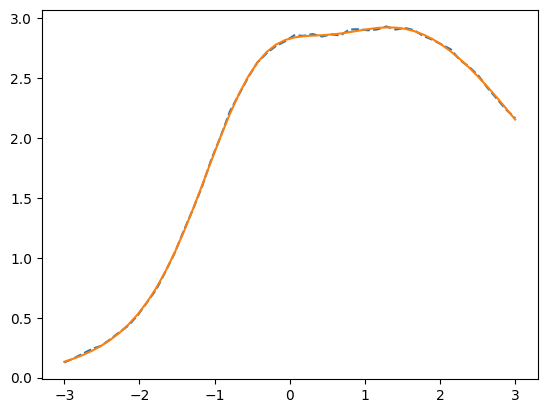

In [14]:
%%time
b1 = (0.0,2.0)
b2 = (-3,3)
b3 = (0.0,3.0)
bnds = (b1, b1, b1, b2, b2, b2, b3, b3, b3)
res = minimize(error_func,w,method='SLSQP',\
                    bounds=bnds, options={'maxiter':10000, 'disp': True})

print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
plt.plot(x, y_true, '--')
plt.plot(x, basis_functions(res.x, x))

# дз

## Генерируем данные

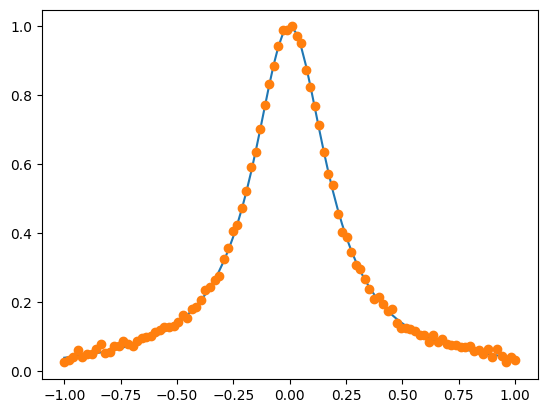

In [65]:
xleft = -1.0; xright = 1.0
n = 100
x = np.linspace(xleft,xright,n) # тренировочные двнные
y = 1./(1.+25.*x**2) # исходная функция без шума

Delta = 0.01*np.random.normal(0, 1, n)
y_true = y + Delta # зашумленная функция

plt.plot(x, y, '-');
plt.plot(x, y_true, 'o');

## Определяем базисные функции и их производные

In [66]:
# радиальные базисные функции
def basis_functions(w, x):
    basis = np.ndarray((len(x), m))
    for i in range(len(x)):
        basis[i] = np.exp(-((x[i] - w[m:m*2]) / w[m*2:m*3])**2)
    return np.sum(basis*w[:m], axis=1)


# первые производные
def basis_functions_deriv(w, x):
    deriv = np.zeros((3*m, len(x)))
    for i in range(3*m):
        if i < m: # a
            deriv[i] = np.exp(-((x - w[m+i]) / w[m*2+i])**2)
        elif i < 2*m: # b
            expon = np.exp(-((x - w[i]) / w[m+i])**2)
            deriv[i] = (2*w[i-m]*(x-w[i])*expon)/(w[i+m]**2)
        elif i < 3*m: # d
            expon = np.exp(-((x - w[i-m]) / w[i])**2)
            deriv[i] =(2*w[i-2*m]*((x-w[i-m])**2)*expon)/(w[i]**3)
    
    return deriv


# вторые производные
def basis_functions_hess(w, x):
    hess = np.zeros((3*m, 3*m, len(x)))
    for i in range(3*m):
        if i < m: # a
            a = w[i]
            b = w[i+m]
            d = w[i+2*m]
            expon = np.exp(-((x - b) / d)**2)
            hess[i, i+m] = (2*(x-b)*expon)/(d**2)
            hess[i, i+2*m] = (2*((x-b)**2)*expon)/(d**3)
            
        elif i < 2*m: # b
            a = w[i-m]
            b = w[i]
            d = w[i+m]
            expon = np.exp(-((x - b) / d)**2)
            hess[i, i-m] = (2*(x-b)*expon)/(d**2)
            hess[i, i] = 2*a*(2*(b**2) - 4*x*b + 2*(x**2) - d**2)*expon/(d**4)
            hess[i, i+m] = -4*a*(b-x)*(b**2 - 2*x*b + x**2 - d**2)*expon/(d**5)
            
        elif i < 3*m: # d
            a = w[i-2*m]
            b = w[i-m]
            d = w[i]
            expon = np.exp(-((x - b) / d)**2)
            hess[i, i-2*m] = (2*((x-b)**2)*expon)/(d**3)
            hess[i, i-m] = -4*a*(x-b)*(d**2 - x**2 + 2*x*b - b**2)*expon/(d**5)
            hess[i, i] = -2*a*((x-b)**2)*(3*(d**2) - 2*(x**2) + 4*b*x - 2*(b**2))*expon/(d**6)
    
    return hess

## Определяем функции ошибок

In [67]:
# функция ошибок аппроксимации
def error_func(w):
    basis = basis_functions(w, x)
    error = 0
    for i in range(len(y_true)):
        error += (basis[i] - y_true[i])**2
    return error

# градиент целевой функции
def error_func_deriv(w):
    basis = basis_functions(w, x)
    basis_deriv = basis_functions_deriv(w, x)
    error_deriv = np.zeros(3*m)
    for i in range(3*m):
        error_deriv[i] = 2*np.sum((basis - y_true)*basis_deriv[i], axis=0)
    return error_deriv

# матрица Гессе целевой функции
def error_func_hess(w):
    basis = basis_functions(w, x)
    basis_deriv = basis_functions_deriv(w, x)
    basis_hess = basis_functions_hess(w, x)
    error_hess = np.zeros((3*m, 3*m))
    for i in range(3*m):
        for j in range(3*m):
            error_hess[i,j] = 2*np.sum((basis_deriv[i]*basis_deriv[j] + basis_hess[i,j]*(basis - y_true)), axis=0)
    return error_hess

## Задаем начальное приближение

In [68]:
m = 3 # number of basis functions
a = np.random.normal(loc=0,scale=3,size=m)
a = [1.0, 1.0, 1.0]
b = np.random.normal(loc=0,scale=1,size=m)
b = [0., 1., 1.5]
d = np.random.normal(loc=0,scale=1,size=m)
d = [2, 5, -3]
w = np.concatenate((a,b,d))
np.set_printoptions(precision=3, suppress=True)
print('Начальные параметры')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(w[i], w[i+m], w[i+2*m]))

print(w)

Начальные параметры
a:   1.000   b:   0.000   d:   2.000
a:   1.000   b:   1.000   d:   5.000
a:   1.000   b:   1.500   d:  -3.000
[ 1.   1.   1.   0.   1.   1.5  2.   5.  -3. ]


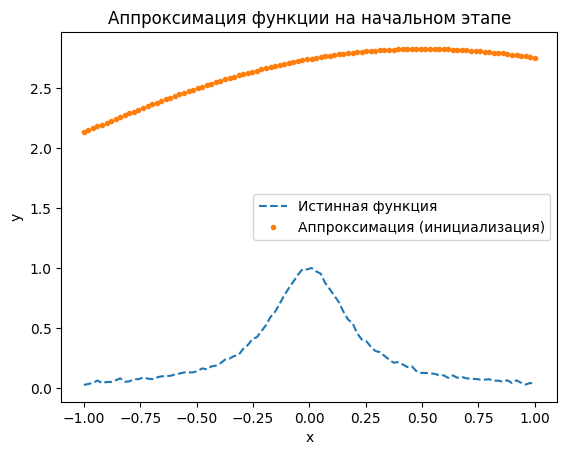

Начальная ошибка: 565.309795899989


In [69]:
plt.plot(x, y_true, '--', label='Истинная функция')
plt.plot(x, basis_functions(w, x), '.', label='Аппроксимация (инициализация)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Аппроксимация функции на начальном этапе')
plt.show()

print('Начальная ошибка:', error_func(w))

## Минимизация методом 0-го порядка

Optimization terminated successfully.
         Current function value: 0.055709
         Iterations: 5232
         Function evaluations: 7476

Параметры аппроксимирующей функции после оптимизации
a:   0.814   b:  -0.005   d:   0.232
a: -10.087   b:   4.371   d:   2.488
a:   4.394   b:   3.464   d:  -2.459
Ошибка после минимизации: 0.05570903354361359
CPU times: user 6.43 s, sys: 606 μs, total: 6.43 s
Wall time: 6.44 s


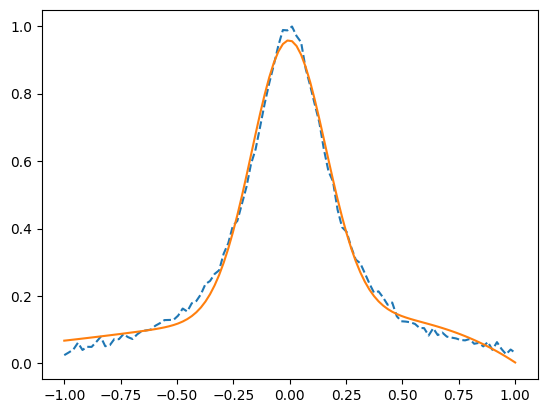

In [70]:
%%time
res = minimize(error_func, w, method='Nelder-Mead',options={'maxiter':10000,'disp': True})
print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
print('Ошибка после минимизации:', res.fun)
plt.plot(x, y_true, '--')
plt.plot(x, basis_functions(res.x, x))

## Минимизация методом 1-го порядка

Optimization terminated successfully.
         Current function value: 0.017520
         Iterations: 98
         Function evaluations: 146
         Gradient evaluations: 146

Параметры аппроксимирующей функции после оптимизации
a:   0.711   b:  -0.001   d:   0.200
a:  -0.132   b:   0.465   d:  -0.003
a:   0.267   b:  -0.006   d:  -0.654
Ошибка после минимизации: 0.017519676939632578
CPU times: user 442 ms, sys: 6.02 ms, total: 448 ms
Wall time: 451 ms


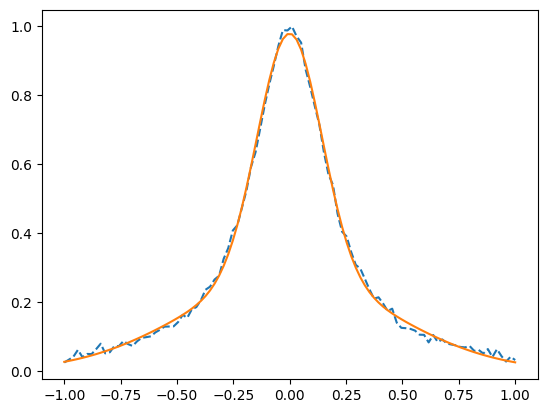

In [71]:
%%time
res = minimize(error_func, w, method='BFGS', jac=error_func_deriv, options={'maxiter':10000, 'disp': True})
print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
print('Ошибка после минимизации:', res.fun)
plt.plot(x, y_true, '--')
plt.plot(x, basis_functions(res.x, x))

## Минимизация методом 2-го порядка

Optimization terminated successfully.
         Current function value: 0.015055
         Iterations: 482
         Function evaluations: 564
         Gradient evaluations: 564
         Hessian evaluations: 482

Параметры аппроксимирующей функции после оптимизации
a:   0.684   b:  -0.001   d:   0.194
a:   1.347   b:   0.473   d:   0.758
a:  -1.208   b:   0.556   d:  -0.677
Ошибка после минимизации: 0.015055149874428676
CPU times: user 2.23 s, sys: 1.92 ms, total: 2.23 s
Wall time: 2.23 s


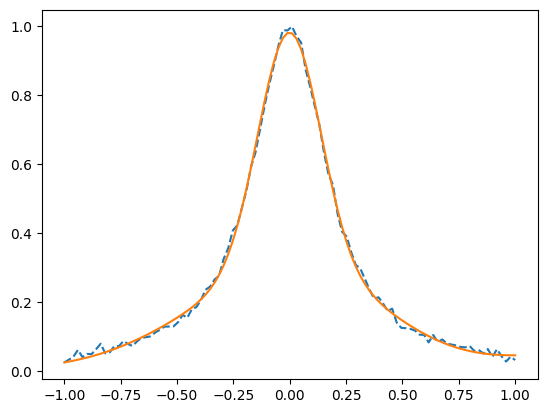

In [72]:
%%time
res = minimize(error_func, w, method='Newton-CG', jac=error_func_deriv, hess=error_func_hess, options={'maxiter':10000, 'disp': True})
print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
print('Ошибка после минимизации:', res.fun)
plt.plot(x, y_true, '--')
plt.plot(x, basis_functions(res.x, x))

## Минимизация с ограничениями

Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.575084202575196
            Iterations: 2
            Function evaluations: 20
            Gradient evaluations: 2

Параметры аппроксимирующей функции после оптимизации
a:   0.000   b:  -3.000   d:   0.000
a:   0.000   b:   3.000   d:   0.000
a:   1.000   b:   1.500   d:   0.000
CPU times: user 62.1 ms, sys: 2.03 ms, total: 64.1 ms
Wall time: 64.6 ms


/tmp/ipykernel_545870/2169853103.py:5: RuntimeWarning: divide by zero encountered in divide
  basis[i] = np.exp(-((x[i] - w[m:m*2]) / w[m*2:m*3])**2)


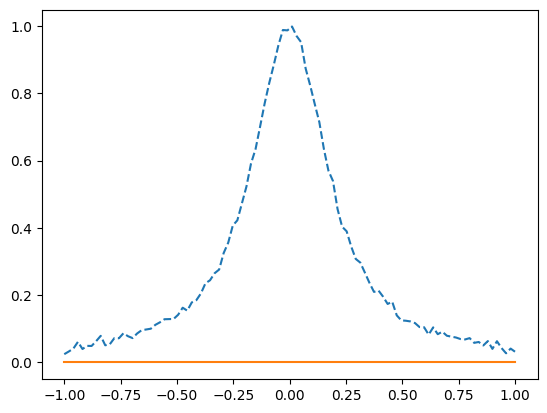

In [73]:
%%time
b1 = (0.0,2.0)
b2 = (-3,3)
b3 = (0.0,3.0)
bnds = (b1, b1, b1, b2, b2, b2, b3, b3, b3)
res = minimize(error_func,w,method='SLSQP',\
                    bounds=bnds, options={'maxiter':10000, 'disp': True})

print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
plt.plot(x, y_true, '--')
plt.plot(x, basis_functions(res.x, x))